In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts/ConceptBottleneck/')
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts')

In [3]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from copy import copy 
import itertools
import json
import argparse 
import resource

In [4]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

In [5]:
from CUB.template_model import InceptionAux, FC, End2EndModel, MLP

In [6]:
torch.cuda.set_per_process_memory_fraction(0.5)
resource.setrlimit(resource.RLIMIT_AS, (30 * 1024 * 1024 * 1024, -1))
torch.set_num_threads(1)

## CLIP

In [10]:
import torch
import clip
from PIL import Image

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 54.4MiB/s]


In [18]:
# Load and preprocess the image
image = preprocess(Image.open("../../../../datasets/CUB/images/100.Brown_Pelican/Brown_Pelican_0141_94533.jpg")).unsqueeze(0).to(device)

# Define your text prompts
text = clip.tokenize(["this is a pelican","this is a bird", "this is a chair"]).to(device)

# Generate embeddings
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

# Normalize the embeddings
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Calculate similarity
similarity = (image_features @ text_features.T).softmax(dim=-1)
print(similarity)


tensor([[0.3535, 0.3362, 0.3103]], device='cuda:0', dtype=torch.float16)


## Set up dataset + model

In [6]:
is_jupyter = 'ipykernel' in sys.modules
if is_jupyter:
    num_objects = 2
    encoder_model='small7'
    seed = 44
    epochs = 50
    expand_dim_encoder = 0
    num_middle_encoder = 0
    train_variation = 'none'
    scale_factor = 1.5
    scale_lr = 5
    model_type = 'joint'
    noisy = False 
    weight_decay = 0.0004
    lr = 0.05
else:
    parser = argparse.ArgumentParser(description="Synthetic Dataset Experiments")


    parser.add_argument('--num_objects', type=int, default=2, help='Number of objects')
    parser.add_argument('--encoder_model', type=str, default='inceptionv3', help='Encoder model')
    parser.add_argument('--seed', type=int, default=42, help='Random seed')
    parser.add_argument('--epochs', type=int, default=50, help='Number of epochs')
    parser.add_argument('--expand_dim_encoder', type=int, default=0, help='For MLPs, size of the middle layer')
    parser.add_argument('--num_middle_encoder', type=int, default=0, help='For MLPs, number of middle layers')
    parser.add_argument('--train_variation', type=str, default='none', help='Either "none", "loss", or "half"')
    parser.add_argument('--scale_lr', type=int, default=5, help='For the half train variation, how much to decrease LR by')
    parser.add_argument('--scale_factor', type=float, default=1.5, help='For the loss train variation, how much to scale loss by')
    parser.add_argument('--model_type', type=str, default='joint', help='"joint" or "independent" model')
    parser.add_argument('--noisy', dest='noisy',default=False,action='store_true')
    parser.add_argument('--weight_decay', default=0.0004,type=float,help="What weight decay to use")
    parser.add_argument('--lr', type=float, default=0.05, help='Learning Rate')

    args = parser.parse_args()
    num_objects = args.num_objects
    encoder_model = args.encoder_model 
    seed = args.seed 
    epochs = args.epochs 
    expand_dim_encoder = args.expand_dim_encoder
    num_middle_encoder = args.num_middle_encoder
    train_variation = args.train_variation 
    scale_factor = args.scale_factor 
    scale_lr = args.scale_lr 
    model_type = args.model_type 
    noisy = args.noisy
    weight_decay = args.weight_decay 
    lr = args.lr 

if noisy:
    dataset_name = "synthetic_object/synthetic_{}_noisy".format(num_objects)
else:
    dataset_name = "synthetic_object/synthetic_{}".format(num_objects)

parameters = {
    'seed': seed, 
    'encoder_model': encoder_model ,
    'epochs': epochs, 
    'num_attributes': num_objects*2,
    'expand_dim_encoder': expand_dim_encoder, 
    'num_middle_encoder': num_middle_encoder, 
    'debugging': False,
    'dataset': dataset_name,
    'weight_decay': weight_decay, 
    'lr': lr, 
}

if train_variation != 'none':
    parameters['train_variation'] = train_variation 

    if train_variation == 'half':
        parameters['scale_lr'] = scale_lr 
    elif train_variation == 'loss':
        parameters['scale_factor'] = scale_factor 

parameters['model_type'] = model_type 

print(parameters)
torch.cuda.set_per_process_memory_fraction(0.5)



{'seed': 44, 'encoder_model': 'small7', 'epochs': 50, 'num_attributes': 4, 'expand_dim_encoder': 0, 'num_middle_encoder': 0, 'debugging': False, 'dataset': 'synthetic_object/synthetic_2', 'weight_decay': 0.0004, 'lr': 0.05, 'model_type': 'joint'}


In [7]:
np.random.seed(seed)
torch.manual_seed(seed)

In [8]:
train_loader, val_loader, test_loader, train_pkl, val_pkl, test_pkl = get_data(num_objects,encoder_model=encoder_model,dataset_name=dataset_name)

In [9]:
test_images, test_y, test_c = unroll_data(test_loader)

In [10]:
log_folder = get_log_folder(dataset_name,parameters).split("/")[-1]
results_folder = "../../results/synthetic/{}".format(log_folder)
if not os.path.exists(results_folder): 
    os.makedirs(results_folder)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [182]:
joint_model = End2EndModel(EqualReceptiveFieldN(2,7,aux_logits=True,
                            n_attributes=4, bottleneck=True, expand_dim=4),  MLP(input_dim=4, num_classes=2, expand_dim=4), False, False, 2)

In [177]:
joint_model = get_synthetic_model(dataset_name,parameters)

In [183]:
joint_model

End2EndModel(
  (first_model): EqualReceptiveFieldN(
    (conv_layers): ModuleList(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (all_fc): ModuleList(
      (0): FC(
        (relu): ReLU()
        (fc_new): Linear(in_features=2048, out_features=4, bias=True)
        (fc): Linear(in_features=4, out_features=1, bias=True)
      )
      (1): FC(
        (relu): ReLU()
        (fc_new): Line

In [170]:
class EqualReceptiveFieldN(nn.Module):
    def __init__(self, num_classes, num_layers,aux_logits=True, transform_input=False, 
                 n_attributes=0, bottleneck=False, expand_dim=0, 
                 three_class=False, connect_CY=False):
        super(EqualReceptiveFieldN, self).__init__()
        self.conv_layers = nn.ModuleList()
        channels = 512
        for i in range(num_layers):
            in_channels = 3 if i == 0 else 2**(i+6)
            out_channels = 2**(i+7) 
            in_channels = min(in_channels,1024)
            out_channels = min(out_channels,1024)
            if i == 0:
                conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size=15-2*(num_layers-1), stride=1, padding=1)
            else:
                conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.conv_layers.append(conv_layer)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.input_size = 256

        dataset = "synthetic"

        if n_attributes == 112:
            dataset = "cub"
        elif n_attributes == 15:
            dataset = "coco"

        # Calculate the output size of the last conv layer before the linear layer
        first_num = min(512,256*2**(num_layers-3))
        
        if dataset == "cub" or dataset == "coco":
            second_num = 37//(2**(num_layers-3))
        elif dataset == "synthetic":
            second_num = 32//(2**(num_layers-3))
        else:
            second_num = 32//(2**(num_layers-3))
        self.conv_output_size = first_num*second_num**2

        self.all_fc = nn.ModuleList()
        
        self.aux_logits = aux_logits
        self.transform_input = transform_input
        self.n_attributes = n_attributes
        self.bottleneck = bottleneck
        if aux_logits:
            self.AuxLogits = InceptionAux(768, num_classes, n_attributes=self.n_attributes, bottleneck=bottleneck, \
                                                expand_dim=expand_dim, three_class=three_class, connect_CY=connect_CY)

        if connect_CY:
            self.cy_fc = FC(n_attributes, num_classes, expand_dim)
        else:
            self.cy_fc = None

            
        if self.n_attributes > 0:
            if not bottleneck: #multitasking
                self.all_fc.append(FC(self.conv_output_size, num_classes, expand_dim))
            for i in range(self.n_attributes):
                self.all_fc.append(FC(self.conv_output_size, 1, expand_dim))
        else:
            self.all_fc.append(FC(self.conv_output_size, num_classes, expand_dim))

    def forward(self, x,binary=False):
        for conv_layer in self.conv_layers:
            x = self.pool(torch.relu(conv_layer(x)))        
        self.last_conv_output = x

        # Flatten the tensor before passing it through the fully connected layers
        x = x.view(-1, self.conv_output_size)
        self.output_before_fc = x

        out = []
        for fc in self.all_fc:
            out.append(fc(x))
        if self.n_attributes > 0 and not self.bottleneck and self.cy_fc is not None:
            attr_preds = torch.cat(out[1:], dim=1)
            if binary:
                attr_preds = torch.round(attr_preds).float()
            
            out[0] += self.cy_fc(attr_preds)
        if self.training and self.aux_logits:
            return out, out
        else:
            return out


In [171]:
def get_receptive_field(model):
    # Initialize input size
    input_size = (1, 3, 224, 224)  # Example input size (batch_size, channels, height, width)
    receptive_field = 1
    
    # Track input size through layers
    with torch.no_grad():
        for module in model.modules():
            if isinstance(module, nn.Conv2d):
                kernel_size = module.kernel_size[0]  # Assuming square kernels
                stride = module.stride[0]  # Assuming square stride
                dilation = module.dilation[0]  # Assuming square dilation
                receptive_field += (kernel_size - 1) * dilation
                receptive_field *= stride
            elif isinstance(module, nn.MaxPool2d):
                kernel_size = module.kernel_size  # Assuming square kernels
                stride = module.stride  # Assuming square stride
                receptive_field *= stride
            elif isinstance(module, nn.ConvTranspose2d):
                kernel_size = module.kernel_size[0]  # Assuming square kernels
                stride = module.stride[0]  # Assuming square stride
                receptive_field += (kernel_size - 1) * stride
            elif isinstance(module, nn.Upsample):
                scale_factor = module.scale_factor
                receptive_field *= scale_factor
                
    return receptive_field


In [172]:
K = [11,3,3]
6+np.sum(2*(np.array(K)-1))

34

In [173]:
get_receptive_field(EqualReceptiveFieldN(4,7,aux_logits=True,
                            n_attributes=4, bottleneck=True, expand_dim=4))

34

In [163]:
# cem_location = "../../cem/results/synthetic/synthetic_2_{}.pth".format(seed)
# probcbm_location = "../../prob-cbm/cem/results/synthetic/ProbCBM_fold_{}.pth".format(seed-41)

In [164]:
# joint_model = torch.load(probcbm_location,map_location='cpu')

In [165]:
# run_model_function = run_probcbm_model
run_model_function = run_joint_model

In [185]:
joint_model = joint_model.to('cuda')

## Plot the Dataset

In [133]:
dataset_directory = "../../../../datasets"

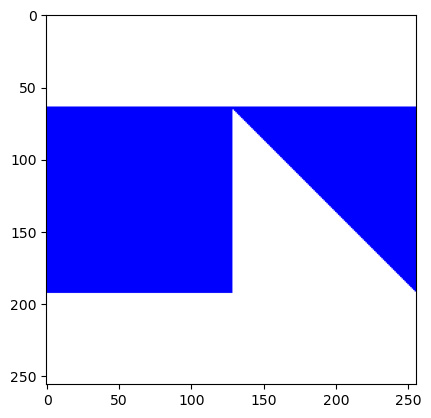

In [134]:
img_path = dataset_directory+'/'+train_pkl[0]['img_path']
image = Image.open(img_path)
plt.imshow(image)

## Analyze Concept-Input Relationships

### Maximal Activation

In [144]:
def numpy_to_pil(img):
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([2, 2, 2])

    unnormalized_image = img * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]
    unnormalized_image = unnormalized_image*255 
    unnormalized_image = np.clip(unnormalized_image, 0, 255).astype(np.uint8) 
    im = Image.fromarray(unnormalized_image.transpose(1,2,0))
    return im

In [186]:
activation_values = []

for concept_num in range(num_objects*2):
    print("On concept {}".format(concept_num))
    val_for_concept = 0
    trials = 5

    for _ in range(trials):
        data_point = random.randint(0,len(test_images)-1)
        input_image = deepcopy(test_images[data_point:data_point+1])
        current_concept_val = test_c[data_point][concept_num]

        ret_image = get_maximal_activation(joint_model,run_model_function,concept_num,
                                        get_valid_image_function(concept_num,num_objects,epsilon=32),fixed_image=input_image,current_concept_val=current_concept_val).to(device)
        predicted_concept = torch.nn.Sigmoid()(run_model_function(joint_model,ret_image)[1].detach().cpu())[concept_num][0].detach().numpy()
        
        val_for_concept += abs(predicted_concept-current_concept_val.detach().numpy())/trials 
        ret_image = ret_image.detach()[0].cpu().numpy()
        im = numpy_to_pil(ret_image) 
        plt.imshow(im)
        im.save("{}/{}.png".format(results_folder,"adversarial_{}".format(concept_num)))
    activation_values.append(val_for_concept)


On concept 0
Output 0 [tensor([[ 0.3385, -0.0384],
        [ 0.3385, -0.0382]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[0.2057],
        [0.2043]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[0.1820],
        [0.1822]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[0.2795],
        [0.2798]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[0.1409],
        [0.1407]], device='cuda:0', grad_fn=<AddmmBackward0>)] 1 [tensor([[ 0.3385, -0.0384],
        [ 0.3385, -0.0382]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[0.2057],
        [0.2043]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[0.1820],
        [0.1822]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[0.2795],
        [0.2798]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[0.1409],
        [0.1407]], device='cuda:0', grad_fn=<AddmmBackward0>)]


TypeError: expected Tensor as element 0 in argument 0, but got list

: 

In [20]:
if model_type == 'independent':
    joint_model[0] = joint_model[0].cpu()
    joint_model[1] = joint_model[1].cpu() 
else: 
    joint_model = joint_model.cpu()
torch.cuda.empty_cache()

## Analyze Saliency Maps

In [21]:
final_data = {
    'adversarial_activations': np.array(activation_values).tolist(),  
    'parameters': parameters, 
    'run_name': log_folder,
}

In [23]:
json.dump(final_data,open("../../results/probcbm_results/probcbm_{}.json".format(seed-41),"w"))